In [ ]:
# Generate Data

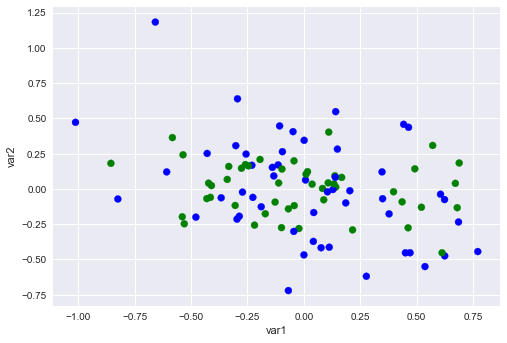

"#3D plot\nfrom mpl_toolkits.mplot3d import Axes3D\nfig = plt.figure()\nax = fig.gca(projection='3d')\nax.scatter(X[:, 0], X[:, 1], X[:, 2], zdir='z', s=20, depthshade=True, \n               color=[['blue', 'green',][int(i)] for i in y])\nplt.show()"

In [145]:
from numpy.random import normal
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np
import pandas as pd

n_ = 100

#2 variables
#doubles gaussiennes toutes les deux


X, y = make_classification(n_samples=n_, 
                           n_features=10, 
                           n_informative=5, 
                           n_redundant=1, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1, 
                           weights=None, 
                           flip_y=0.05,
                           class_sep=1.0,
                           hypercube=True,
                           shift=0.0,
                           scale=1.0,
                           shuffle=True,
                           random_state=None)
#scale -1; 1
X = (X - X.mean(axis=0))/list(map(max, zip(abs(X.max(axis=0)), abs(X.min(axis=0)))))


#2D plot
plt.scatter(X[:, 0], X[:, 1], color=[['blue', 'green'][int(i)] for i in y])
plt.xlabel('var1')
plt.ylabel('var2')
plt.show()


'''#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], zdir='z', s=20, depthshade=True, 
               color=[['blue', 'green',][int(i)] for i in y])
plt.show()'''

# Train a Classifier

In [146]:
'''
This script tests implementation of a usage of LIME https://github.com/marcotcr/lime
'''
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import random


X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))

clf.feature_importances_

accuracy  0.92


array([ 0.03441111,  0.02697426,  0.03402563,  0.48111716,  0.04101825,
        0.15110328,  0.00521207,  0.15019207,  0.04882271,  0.02712346])

# LIME

In [81]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=['var' + str(i) for i in range(X.shape[1])],#, 'var3'],
                                                   #class_names=list(map(str, iris.target_names)),
                                                   discretize_continuous=False,
                                                   verbose=True)
exp = explainer.explain_instance(X_test[idx], clf.predict_proba, num_features=5, top_labels=1)
print('score du fit du local au global', exp.score)


exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.471661281013
Prediction_local [ 0.74439627]
Right: 0.7
score du fit du local au global 0.505533326827


# Distance Matrix

In [152]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X_test, metric='euclidean') 

### Picking the closest neighbors

In [153]:
idx = np.random.randint(X_test.shape[0])
neighbors_s = sorted(zip(range(D.shape[0]), D[idx, :], y_pred), key=lambda x: x[1])

def knn(neighbors, k=10, class_=None):
    if class_ == None:
        return neighbors[1:k+1]
    else:
        c_ = [x for x in neighbors if x[2]==class_]
        return c_[:k]


### Generating new observations between the observation and its neighbors

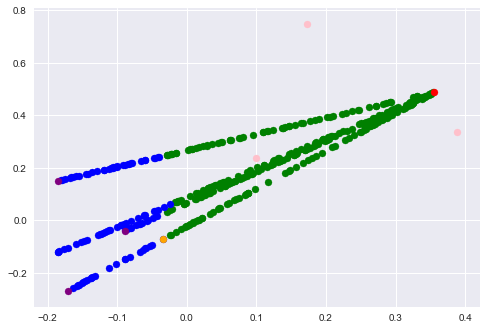

In order to cross the border, this observation would need:
-0.079372 in variable 0 (-0.430453, 0.606538)
-0.173857 in variable 1 (-0.550130, 0.446704)
0.079314 in variable 2 (-0.408769, 0.588136)
-0.388489 in variable 3 (-0.464964, 0.387985)
-0.047148 in variable 4 (-0.798813, 0.958685)
-0.557459 in variable 5 (-0.730806, 0.746982)
0.075327 in variable 6 (-0.671082, 0.513573)
-0.008645 in variable 7 (-0.748553, 0.407188)
0.091882 in variable 8 (-0.471532, 0.692502)
-0.256392 in variable 9 (-0.957470, 0.994865)


In [155]:
### 
import random

N = 4
AX1, AX2 = 3, 5

enn_ = [X_test[x[0]] for x in knn(neighbors_s, N, (1-y_pred[idx]))]
all_ = [X_test[x[0]] for x in knn(neighbors_s, N, (y_pred[idx]))[1:]]

#enn_ = enn_ + [X_test[idx] + [0.0 , 4.0, 0.0], X_test[idx] + [0.0 , -4.0, 0.0]]

d0 = 10000000000
for neigh in enn_:
    for i in range(100):
        alpha = random.random()
        new = alpha * X_test[idx] + (1 - alpha) * neigh
        pred_ = clf.predict(new.reshape(1, -1))[0]
        d_ = (sum((new - X_test[idx])**2))**(0.5)
        if (pred_ != y_pred[idx]) and d_ < d0:
            d0 = d_
            border = new
        c_ = ['blue', 'green'][pred_]
        plt.scatter(new[AX1], new[AX2], color=c_)

plt.scatter(X_test[idx, AX1], X_test[idx, AX2], color='red')
plt.scatter(enn_[0][AX1], enn_[0][AX2], color='purple')
plt.scatter(enn_[1][AX1], enn_[1][AX2], color='purple')
plt.scatter(enn_[2][AX1], enn_[2][AX2], color='purple')
plt.scatter(all_[0][AX1], all_[0][AX2], color='pink')
plt.scatter(all_[1][AX1], all_[1][AX2], color='pink')
plt.scatter(all_[2][AX1], all_[2][AX2], color='pink')
plt.scatter(border[AX1], border[AX2], color='orange')


plt.show()


#print(X[idx], nn_[0],  border)


print('In order to cross the border, this observation would need:')
for v in range(X_test.shape[1]):
    print('%f in variable %d (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[:, v].min(), X_test[:, v].max()))


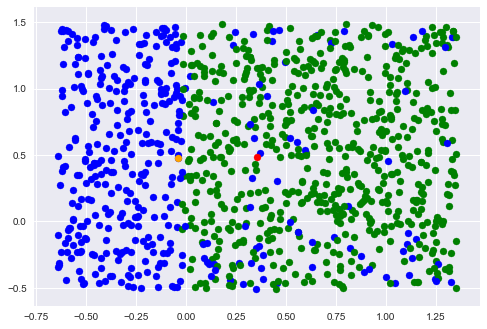

In order to cross the border, this observation would need:
-0.488791 in variable 0 (-0.430453, 0.606538)
0.254728 in variable 1 (-0.550130, 0.446704)
0.389250 in variable 2 (-0.408769, 0.588136)
-0.397180 in variable 3 (-0.464964, 0.387985)
-0.127647 in variable 4 (-0.798813, 0.958685)
-0.007569 in variable 5 (-0.730806, 0.746982)
0.010453 in variable 6 (-0.671082, 0.513573)
-0.225421 in variable 7 (-0.748553, 0.407188)
0.448229 in variable 8 (-0.471532, 0.692502)
0.408813 in variable 9 (-0.957470, 0.994865)


In [158]:
### Faire grandir un cube autour (boule oula compliqué)
AX1, AX2 = 3, 5
r = 2

d0 = 1000000000
for i in range(1000):
    new = np.array([-1 +X_test[idx][d] + r * random.random() for d in range(X_test.shape[1])])
    pred_ = clf.predict(new.reshape(1, -1))[0]
    d_ = (sum((new - X_test[idx])**2))**(0.5)
    if (pred_ != y_pred[idx]) and d_ < d0:
        d0 = d_
        border = new
    c_ = ['blue', 'green'][pred_]
    plt.scatter(new[AX1], new[AX2], color=c_)
plt.scatter(X_test[idx, AX1], X_test[idx, AX2], color='red')
plt.scatter(border[AX1], border[AX2], color='orange')
plt.show()


print('In order to cross the border, this observation would need:')
for v in range(X_test.shape[1]):
    print('%f in variable %d (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[:, v].min(), X_test[:, v].max()))


### Test lien proba distance

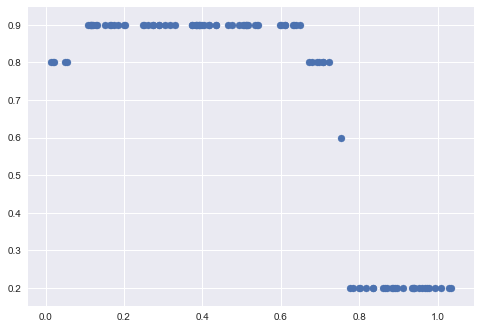

In [159]:
### 
import random

N = 1
AX1, AX2 = 0, 1

enn_ = [X_test[x[0]] for x in knn(neighbors_s, N, (1-y_pred[idx]))]
all_ = [X_test[x[0]] for x in knn(neighbors_s, N, (y_pred[idx]))[1:]]

#enn_ = enn_ + [X_test[idx] + [0.0 , 4.0, 0.0], X_test[idx] + [0.0 , -4.0, 0.0]]

d0 = 10000000000
dist, probas = [], []
for neigh in enn_:
    for i in range(100):
        alpha = random.random()
        new = alpha * X_test[idx] + (1 - alpha) * neigh
        pred_prob = clf.predict_proba(new.reshape(1, -1))[0]
        d_ = (sum((new - X_test[idx])**2))**(0.5)
        dist.append(d_)
        probas.append(pred_prob[1])
plt.scatter(dist, probas)
plt.show()



### Test marche aléatoire

In [123]:
AX1, AX2 = 0, 1

start, prob_start = X_test[idx], clf.predict_proba(X_test[idx].reshape(1, -1))[0][1]
goal= int(prob_start<0.5)
print(start, prob_start, goal)
i = 0
pred = int(prob_start>=0.5)

def progress(prob1, prob2):
    if prob1>= 0.5:
        return prob2<=prob1
    else:
        return prob2>=0.5

def color(obs):
    return ['blue', 'green'][clf.predict(obs.reshape(1, -1))[0]]

while pred != goal:
    i += 1
    alpha = random.uniform(-3, 3)
    direction = random.randint(0, 2)
    new = np.array(start + [alpha if i==direction else 0 for i in range(X_test.shape[1])])
    prob_new = clf.predict_proba(new.reshape(1,-1))[0][1]
    if progress(prob_start, prob_new):
        print(i, prob_start, prob_new, new)
        plt.scatter(new[AX1], new[AX2], color='orange')
        plt.plot([start[AX1], new[AX1]], [start[AX2], new[AX2]], color='purple')
        start = new
        prob_start = prob_new
        pred = int(prob_new>=0.5)
        
        import pdb;pdb.set_trace()

plt.scatter(X_test[idx][AX1], X_test[idx][AX2], color=color(X_test[idx]))
plt.scatter(new[AX1], new[AX2], color=color(new))


plt.show()
print('In order to cross the border, this observation would need:')
for v in range(X_test.shape[1]):
    print('%f in variable %d (%f, %f)' %(new[v] - X_test[idx, v], v, X_test[:, v].min(), X_test[:, v].max()))

[ 0.25121615 -3.15044507  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038] 1.0 0
1 1.0 1.0 [-1.56750452 -3.15044507  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
2 1.0 1.0 [-1.56750452 -0.33745148  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
3 1.0 1.0 [-1.56750452 -2.32630571  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
4 1.0 1.0 [-1.56750452 -2.32630571  1.00704129 -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
5 1.0 1.0 [-1.56750

BdbQuit: 

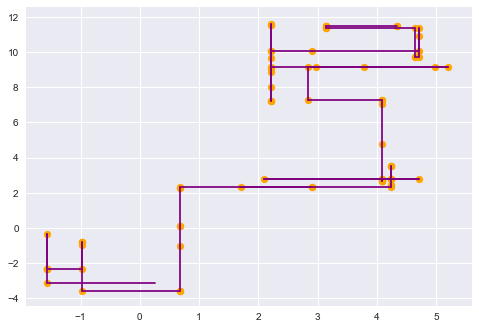

In [124]:
plt.show()

In [122]:
idx = np.random.randint(X_test.shape[0])